In [1]:
import numpy as np
from sklearn import preprocessing
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale, normalize

with open('data/data2D.csv', 'r') as f: 
    X = np.genfromtxt(f, dtype='f4', delimiter=',')
with open('data/data1000D.csv', 'r') as f: 
    X1k = np.genfromtxt(f, dtype='f4', delimiter=',')

## PCA using SVD

In [2]:
def mean(x):
    return sum(x)/len(x)  

def covariance(x): 
    return (x.T @ x)/(x.shape[0]-1)

def std(x):
    return (sum((i - mean(x))**2 for i in x)/len(x))**0.5

def losscal(X,X_inv):
  loss = np.sum(np.average((X - X_inv) ** 2, axis=0))
  return loss

def Standardize_data(x):
    xmean = mean(x)
    xstd = std(x)
    return (x - xmean)/xstd, xmean, xstd

In [9]:
def PCA_SVD(X,k):
  _, _, vt = np.linalg.svd(X, full_matrices=False)
  eb_m_ = vt[:k]
  return eb_m_

def Buggy_PCA(X,d):
    A=PCA_SVD(X,d)
    Z = X@A.T
    X_rev=(Z@A)
    return Z, A, X_rev

def Demean_PCA(X,d):    
    Xmean = mean(X)
    Xin=X-Xmean
    A=PCA_SVD(Xin,d)
    Z = Xin@A.T
    X_rev=(Z@A)+Xmean
    return Z, (A, Xmean), X_rev

def Stand_PCA(X,d): 
    Xin, Xmean, Xstd =Standardize_data(X)
    A=PCA_SVD(Xin,d)
    Z = Xin@A.T
    X_rev=(Z@A)*Xstd+Xmean
    return Z, (A, Xmean, Xstd), X_rev

### Buggy PCA

Buggy PCA Loss=0.8869029879570007


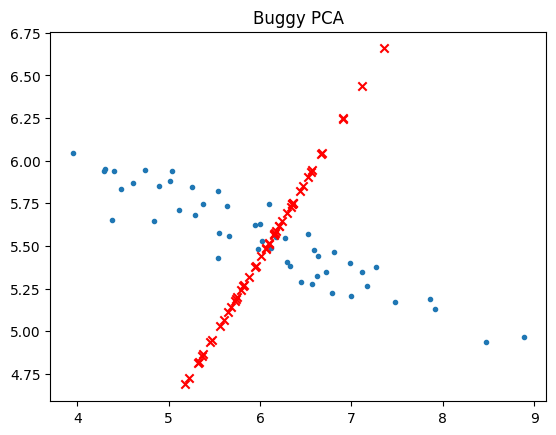

In [48]:
_, _, X_rev = Buggy_PCA(X,1)
print(f"Buggy PCA Loss={losscal(X,X_rev)}")
plt.scatter(X[:,0],X[:,1], marker='.')
plt.scatter(X_rev[:, 0], X_rev[:, 1], c='r', marker='x')
plt.title("Buggy PCA")
plt.show()

### Demeaned PCA

Demeaned PCA Loss=0.010006079450249672


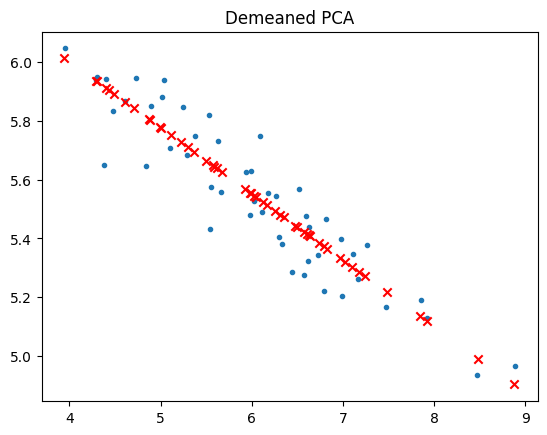

In [49]:
_, _, X_rev = Demean_PCA(X,1)
print(f"Demeaned PCA Loss={losscal(X,X_rev)}")
plt.scatter(X[:,0],X[:,1], marker='.')
plt.scatter(X_rev[:, 0], X_rev[:, 1], c='r', marker='x')
plt.title("Demeaned PCA")
plt.show()   

### Standarized PCA

Standardized PCA Loss=0.04947206750512123


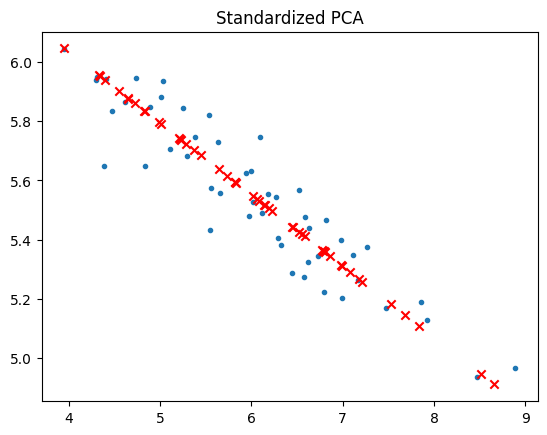

In [50]:
_, _, X_rev = Stand_PCA(X,1)
print(f"Standardized PCA Loss={losscal(X,X_rev)}")
plt.scatter(X[:,0],X[:,1], marker='.')
plt.scatter(X_rev[:, 0], X_rev[:, 1], c='r', marker='x')
plt.title("Standardized PCA")
plt.show()

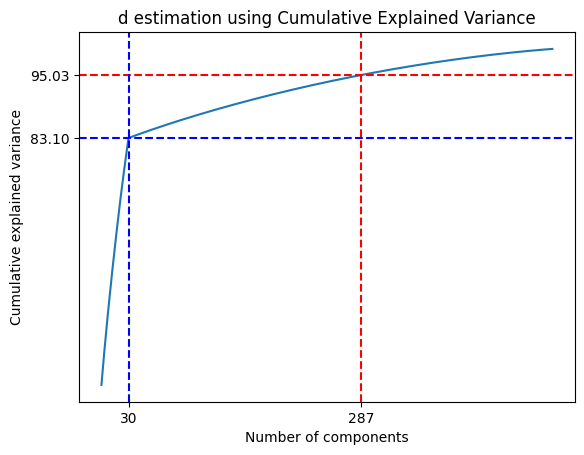

In [52]:
u, sig, vt = np.linalg.svd(X1k,full_matrices=False)
sigsum= sum(sig)

expvar = [(i / sigsum)*100 for i in sig]

cum_explvar = np.cumsum(expvar)

x=np.array(range(sig.shape[0]))

plt.plot(x, cum_explvar)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

kneepoint = 30

lim95 = np.argmax(cum_explvar>95)

plt.axvline(lim95, color='red', linestyle='--')
plt.axhline(cum_explvar[lim95], color='red', linestyle='--')
plt.axvline(kneepoint, color='blue', linestyle='--')
plt.axhline(cum_explvar[kneepoint], color='blue', linestyle='--')
plt.xticks([lim95, kneepoint])
plt.yticks([cum_explvar[lim95], cum_explvar[kneepoint]])
plt.title("d estimation using Cumulative Explained Variance")
plt.show()

The number of dimensions after which we can explain atleast 95% of the variance in the dataset is considered a good number of components for PCA. In our case that number turns out of 287. Rounding it upto an even 300 is a good number of components and much less than the original 1000 we had.

We also observe a knee point at around 30 components which is able to explain 83.10% variance in the data and while its a good estimate with much less number of components its not a satisfactory estimate and may result in errors which we will see below.

In [16]:
_, _, X_rev_bug = Buggy_PCA(X1k,30)
print(f"Buggy PCA Loss with 30 component={losscal(X1k,X_rev_bug)}")
_, _, X_rev_bug = Buggy_PCA(X1k,300)
print(f"Buggy PCA Loss with 300 components={losscal(X1k,X_rev_bug)}")

_, _, X_rev_demean = Demean_PCA(X1k,30)
print(f"Demeaned PCA Loss with 30 component={losscal(X1k,X_rev_demean)}")
_, _, X_rev_demean = Demean_PCA(X1k,300)
print(f"Demeaned PCA Loss with 300 component={losscal(X1k,X_rev_demean)}")

_, _, X_rev_stand = Stand_PCA(X1k,30)
print(f"Standardized PCA Loss with 30 component={losscal(X1k,X_rev_stand)}")
_, _, X_rev_stand = Stand_PCA(X1k,300)
print(f"Standardized PCA Loss with 300 components={losscal(X1k,X_rev_stand)}")

Buggy PCA Loss with 30 component=802.7313232421875
Buggy PCA Loss with 300 components=43.38435745239258
Demeaned PCA Loss with 30 component=273.04595947265625
Demeaned PCA Loss with 300 component=43.05983352661133
Standardized PCA Loss with 30 component=273.6285705566406
Standardized PCA Loss with 300 components=44.56665802001953


### DRO

In [44]:
def DRO(X,k):
    X_meaned = X-mean(X)
    cov_mat = covariance(X_meaned) 

    eig_vals, eig_vecs = np.linalg.eig(cov_mat) 

    max_abs_idx = np.argmax(np.abs(eig_vecs), axis=0)
    signs = np.sign(eig_vecs[max_abs_idx, range(eig_vecs.shape[0])])
    eig_vecs = eig_vecs*signs[np.newaxis,:]
    eig_vecs = eig_vecs.T

    eig_sort = list(reversed(np.argsort(eig_vals)))
    eig_val_sorted = eig_vals[eig_sort]
    eig_vecs_sorted = eig_vecs[eig_sort]

    A = eig_vecs_sorted[:k, :]
    Z = X_meaned@A.T
    X_rev=(Z@A)+mean(X)

    return Z, (A, X_meaned, zip(eig_val_sorted,eig_vecs_sorted)), X_rev

DRO Loss with 30 component=0.010006076656281948


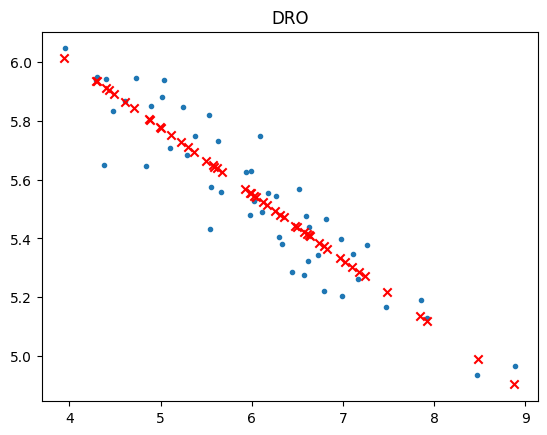

In [53]:
_, _, X_rev=DRO(X, 1)
print(f"DRO Loss with 30 component={losscal(X, X_rev)}")
plt.scatter(X[:,0],X[:,1], marker='.')
plt.scatter(X_rev[:, 0], X_rev[:, 1], c='r', marker='x')
plt.title("DRO")
plt.show()

In [54]:
_, _, X_rev_dro=DRO(X1k, 30)
print(f"Buggy PCA Loss with 30 component={losscal(X1k, X_rev_dro)}")
_, _, X_rev_dro=DRO(X1k, 300)
print(f"Buggy PCA Loss with 300 component={losscal(X1k, X_rev_dro)}")

Buggy PCA Loss with 30 component=273.04595947265625
Buggy PCA Loss with 300 component=43.059837341308594
